In [3]:
import torch, torchaudio, random
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from hs_hackathon_drone_acoustics.base import AudioDataset, AudioWaveform
from hs_hackathon_drone_acoustics import CLASSES
import torchaudio.transforms as T
import sys
import torch.nn as nn
import torch.nn.functional as F
sys.path.append("../scripts")
from gen_torch_datasets import (
    gen_dataloaders, to_cuda, 
    plot_metrics, plot_confusion_matrix, plot_ds_examples
)

import random

from nbformat import convert
from sympy import false
import torchaudio.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # Make sure tqdm is installed
import matplotlib.pyplot as plt

from hs_hackathon_drone_acoustics import CLASSES, RAW_DATA_DIR


SR = int(44100 / 2000)
DUR = 5.0
N_SAMPLES = int(SR * DUR)

# Optional waveform-domain augmenters
pitch_up = torchaudio.transforms.PitchShift(SR, n_steps=+1.5)  # semitones

def add_uniform_noise(wave, snr_db=5.0):
    # Uniform noise in [-1, 1]
    noise = torch.rand_like(wave) * 2 - 1
    return mix_background(wave, noise, snr_db)

def mix_background(wave, noise, snr_db=5.0):
    # simple SNR-based mixing: scale noise to target SNR
    s_pow = wave.pow(2).mean()
    n_pow = noise.pow(2).mean() + 1e-12
    target = s_pow / (10 ** (snr_db / 10))
    noise = noise * (target / n_pow).sqrt()
    return (wave + noise).clamp(-1, 1)

class AudioDatasetAugmented(Dataset[tuple[AudioWaveform, int]]):
    def __init__(self, root_dir: Path, training:bool) -> None:
        if not root_dir.is_dir():
            raise FileNotFoundError(f"{root_dir} is not a directory")
        self._root_dir = root_dir
        self._training = training
        self._filepaths: list[Path] = []
        self._labels: list[int] = []
        self._class_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}
        # Parse labels and filenames from class directories
        self.noise_pool = [0.5]
        for clz in CLASSES:
            class_dir = root_dir / clz
            for file_name in class_dir.glob("*.wav"):
                self._filepaths.append(class_dir / file_name)
                self._labels.append(self._class_to_idx[clz])

    def __len__(self) -> int:
        return len(self._filepaths)

    def __getitem__(self, idx: int | slice) -> tuple[AudioWaveform, int] | tuple[list[AudioWaveform], list[int]]:
        if isinstance(idx, int):
            wav = AudioWaveform.load(self._filepaths[idx])
            data = wav.data
            label = self._labels[idx]
            if self._training:
                r = random.random()
                if r < 0.25:
                    data = pitch_up(data)
                elif r < 0.75:
                    # add background noise from pool (already preloaded as tensors at SR)
                    noise = random.choice(self.noise_pool)
                    data = add_uniform_noise(data)
                else:
                    data = data  # no-op
                # spectogram
            resample = T.Resample(wav.sample_rate, 16_000)
            waveform_to_spectrogram = T.Spectrogram(win_length=4096, n_fft=4096, hop_length=2048)
            db_transform = T.AmplitudeToDB(stype="power", top_db=80)
            spect = db_transform(waveform_to_spectrogram(resample(data)))
            return spect, label
        else:
            list_waveforms = []
            labels = []
            for sub_idx in range(len(self))[idx]:
                single_waveform, single_label = self.__getitem__(sub_idx)
                list_waveforms.append(single_waveform)
                labels.append(single_label)
            return list_waveforms, labels

In [4]:
RAW_DATA_DIR = Path("/home/henrik/Documents/EDTH/CPH2025/drone_acoustics_train_val_data")

TRAIN_PATH = RAW_DATA_DIR / "train"
VAL_PATH = RAW_DATA_DIR / "val"

train_dataset = AudioDatasetAugmented(root_dir=TRAIN_PATH, training=True)
val_dataset = AudioDatasetAugmented(root_dir=VAL_PATH, training=False)

item = train_dataset[0]

Train dataset size: 981
Validation dataset size: 180


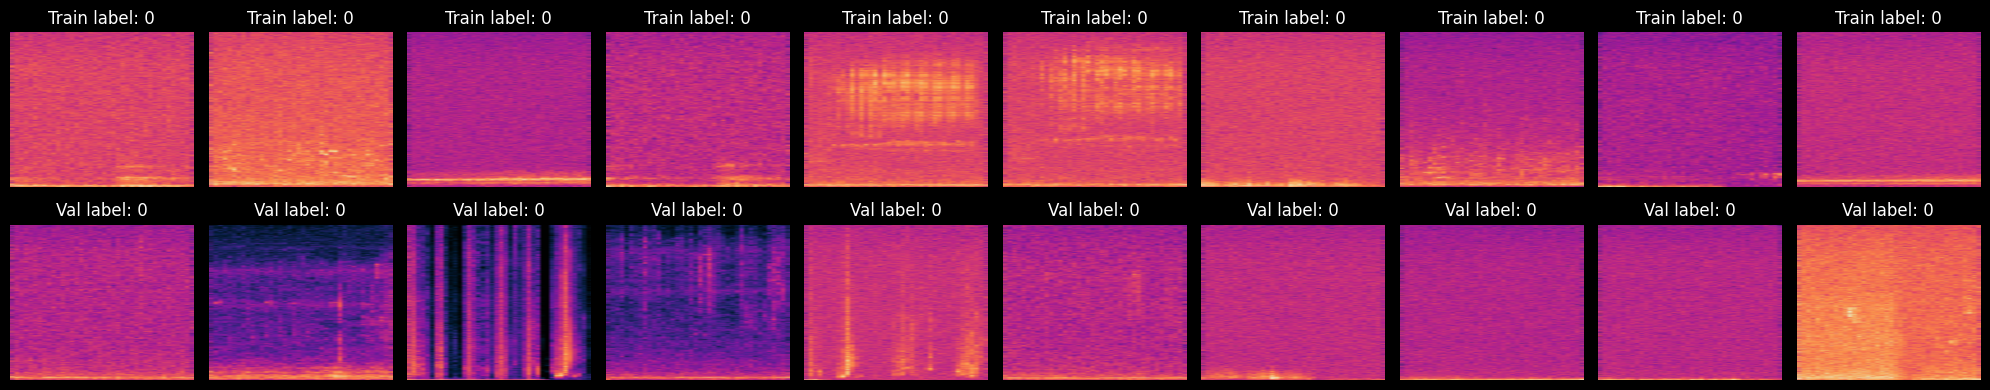

In [5]:
plot_ds_examples(train_dataset, val_dataset)

In [6]:
batch_size = 48
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
input_shape = (2049, 40)
num_classes = 3


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

time_masks = torch.nn.ModuleList([
    torchaudio.transforms.TimeMasking(time_mask_param=random.randint(20, 28))
    for _ in range(2)
])
freq_masks = torch.nn.ModuleList([
    torchaudio.transforms.FrequencyMasking(freq_mask_param=random.randint(4, 8))
    for _ in range(2)
])

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class SpectrogramResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, dropout=0.3, reduction=16):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction)
        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

class SpectrogramResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.layer1 = SpectrogramResNetBlock(32, 64, downsample=True, dropout=0.0)
        self.layer2 = SpectrogramResNetBlock(64, 128, downsample=True, dropout=0.0)
        self.layer3 = SpectrogramResNetBlock(128, 256, downsample=True, dropout=0.1)
        # self.layer4 = SpectrogramResNetBlock(256, 256, downsample=False, dropout=0.4)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        if self.training:
            for m in time_masks: x = m(x)
            for m in freq_masks: x = m(x)
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [8]:
import torch.nn as nn
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np 

model = SpectrogramResNet(num_classes=num_classes)
# model.load_state_dict(torch.load("/home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.7500.pth"))
model, device = to_cuda(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
metrics = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

# Training loop
savepath = "/home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models"
for epoch in tqdm(range(200)):
    model.train()
    correct = 0
    total = 0
    acc = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
        acc = correct / total
        optimizer.step()
    metrics["train_loss"].append(loss.item())
    metrics["train_acc"].append(acc)

    # Validation accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    acc = correct / total
    
    if len(metrics["val_acc"]) > 1:
        if acc > np.amax(metrics["val_acc"]): 
            print("Saved model:", f"{savepath}/best_val{acc:.4f}.pth")
            torch.save(model.state_dict(), f"{savepath}/best_val{acc:.4f}.pth")
    
    metrics["val_acc"].append(acc)


Number of GPUs: 1
Device 0: NVIDIA GeForce RTX 2080 SUPER


  2%|▏         | 3/200 [00:37<41:00, 12.49s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.5722.pth


  2%|▎         | 5/200 [01:02<39:47, 12.24s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.6111.pth


  3%|▎         | 6/200 [01:14<39:59, 12.37s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.6611.pth


  4%|▍         | 9/200 [01:51<38:58, 12.24s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.6667.pth


  7%|▋         | 14/200 [02:53<38:32, 12.43s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.7167.pth


  8%|▊         | 17/200 [03:30<37:56, 12.44s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.7222.pth


 10%|█         | 21/200 [04:21<37:21, 12.52s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.7444.pth


 11%|█         | 22/200 [04:33<37:01, 12.48s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.7500.pth


 14%|█▍        | 28/200 [05:47<35:25, 12.36s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.7722.pth


 20%|██        | 40/200 [08:14<32:41, 12.26s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.7833.pth


 24%|██▍       | 49/200 [10:05<30:53, 12.27s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.7889.pth


 26%|██▋       | 53/200 [10:54<30:00, 12.25s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.7944.pth


 29%|██▉       | 58/200 [11:55<28:45, 12.15s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.8000.pth


 30%|███       | 60/200 [12:19<28:25, 12.18s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.8111.pth


 49%|████▉     | 98/200 [20:08<21:02, 12.38s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.8167.pth


 70%|██████▉   | 139/200 [28:33<12:27, 12.26s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.8222.pth


 96%|█████████▌| 192/200 [39:23<01:37, 12.25s/it]

Saved model: /home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.8389.pth


100%|██████████| 200/200 [41:01<00:00, 12.31s/it]


Max Acc: 0.8388888888888889


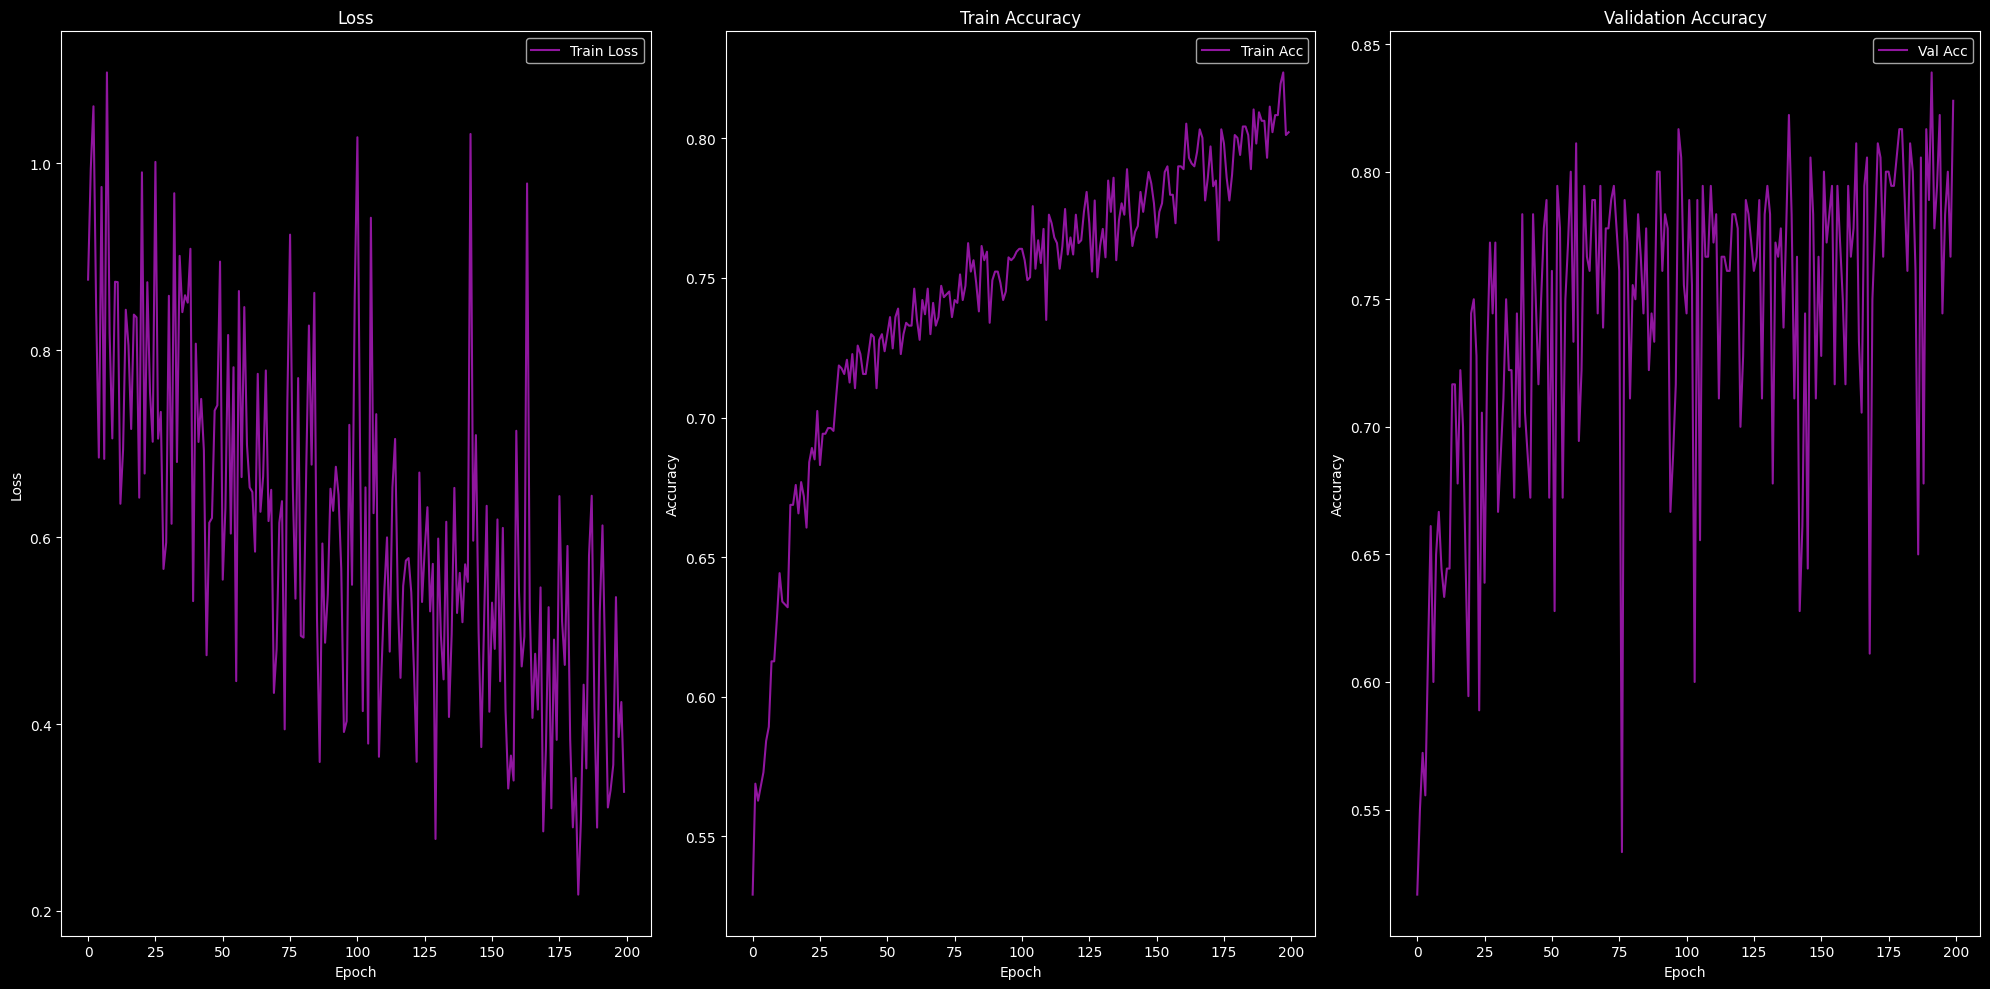

0.8236493374108053
0.8388888888888889


In [9]:
plot_metrics(metrics)
print(np.amax(metrics["train_acc"]))
print(np.amax(metrics["val_acc"]))

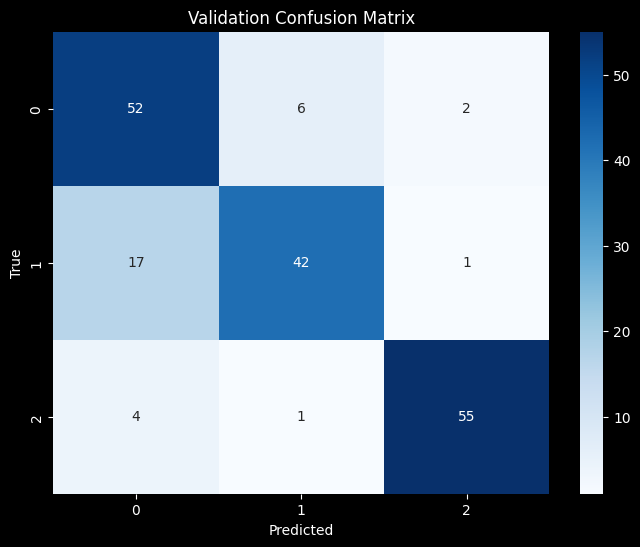

In [10]:
plot_confusion_matrix(model, device, num_classes, val_loader)

In [11]:
model = SpectrogramResNet(num_classes=3)
model.load_state_dict(torch.load(
    "/home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models/best_val0.8278.pth"))  # if you saved weights earlier
model.eval()

dummy_input = torch.randn(1, 1, 2049, 40)
savepath = "/home/henrik/Documents/EDTH/CPH2025/EDTHCPH2025/models"
torch.onnx.export(
    model,                     # model instance
    dummy_input,               # example input
    f"{savepath}/best8278.onnx",              # filename
    export_params=True,        # store trained params inside the model
    opset_version=17,          # ONNX opset (17 is good for current runtimes)
    do_constant_folding=True,  # optimize constant ops
    input_names=["input"],     # name the inputs
    output_names=["output"],   # name the outputs
    dynamic_axes={             # allow dynamic batch size, time/freq
        "input": {0: "batch"},
        "output": {0: "batch"}
    }
)
print("ONNX model exported -> model.onnx")
model, device = to_cuda(model)

ONNX model exported -> model.onnx
Number of GPUs: 1
Device 0: NVIDIA GeForce RTX 2080 SUPER


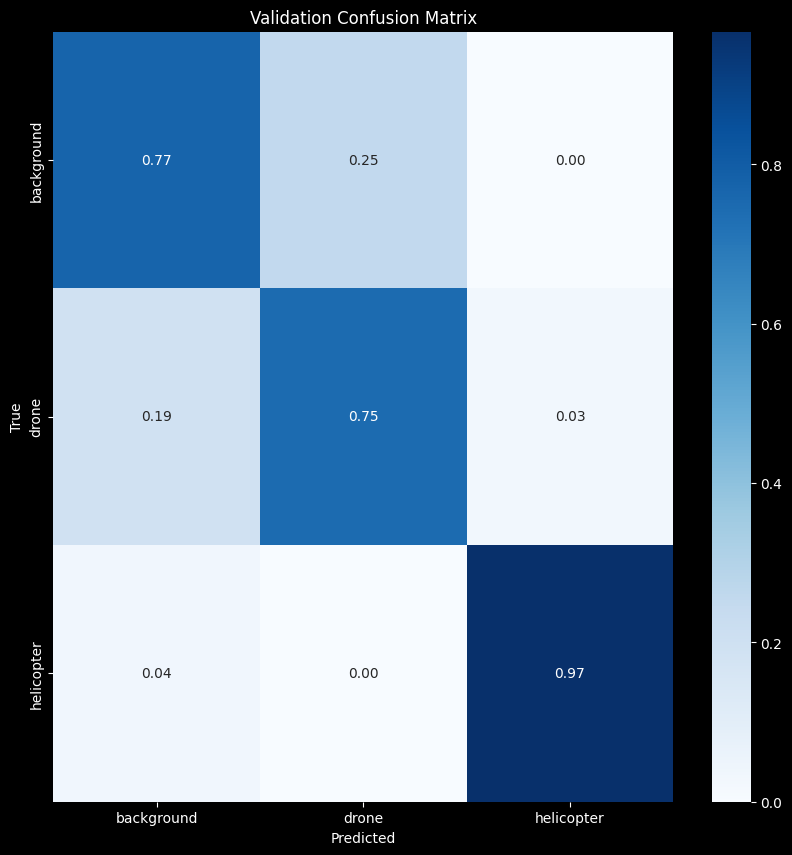

In [12]:
import seaborn as sns
def plot_confusion_matrix_labels(model, device, n_classes, ds_loader):
    # Suppose cm is your confusion matrix (2D numpy array)
    cm = np.zeros((n_classes, n_classes), dtype=int)

    # Collect predictions and fill cm
    model.eval()
    with torch.no_grad():
        for X, y in ds_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            for t, p in zip(y.cpu().numpy(), predicted.cpu().numpy()):
                cm[t, p] += 1

    # Plot using seaborn
    display = cm.astype(float)
    display = display / np.clip(display.sum(axis=0, keepdims=True), 1, None)
    fmt = ".2f"
    cbar_label = "Proportion (per predicted class)"
    cbar_label = "Proportion (overall)"
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(display, annot=True, fmt=fmt, cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticklabels(["background", "drone", "helicopter"])
    ax.set_yticklabels(["background", "drone", "helicopter"])
    ax.set_title("Validation Confusion Matrix")
    plt.show()
    
plot_confusion_matrix_labels(model, device, num_classes, val_loader)